In [1]:
import numpy as np 
from scipy.stats import chi2
import sys, os, pickle 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 

sys.path.append('../../')
from project.recoil import Electron as El, p50, norm, get_vdf_ert
from project.electron_pll import MLE
from project.electron_pll import StatisticalUncertanity as Stat 
from project.electron_pll import MassModelUncertanity as MassModel
from project.electron_pll import SampleUncertanity as Samp 

import matplotlib
matplotlib.rcParams['font.family'] = 'sans'
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'

In [2]:
MWlike = pickle.load(open('../../Output/MWlike_dict.pkl','rb'))
mwld = MWlike['vdf_RCfit']
mwd = mwld['MW']
mwgals = MWlike['mwgals']
rate_prediction = pickle.load(open('../../Output/El_rate_prediction.pkl', 'rb'))

In [3]:
el_init = El('Si', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']))
mdm0, sdm0, bl0 = 5., 1e-38, 1.
mock = el_init.mocksample(mdm0, sdm0, bl0, 3.8, exposure=1, seed=5222)
print (el_init.totNsg(mdm0, sdm0, exposure=1))

715.2236247411968


In [4]:
stat = Stat(mock, el_init=el_init, Mdm=np.linspace(3, 7, 100))

Mdm = np.array(list(rate_prediction['massmodel']['MW'][0].keys()))
mm = MassModel(mock, el_init=el_init, Mdm=Mdm, chainlen=50)

Mdm = np.array(list(rate_prediction['sample'][11].keys()))
samp = Samp(mock, el_init=el_init, Mdm=Mdm, percentiles=np.arange(11, 96, 2))

100%|██████████| 43/43 [00:00<00:00, 8011.15it/s]


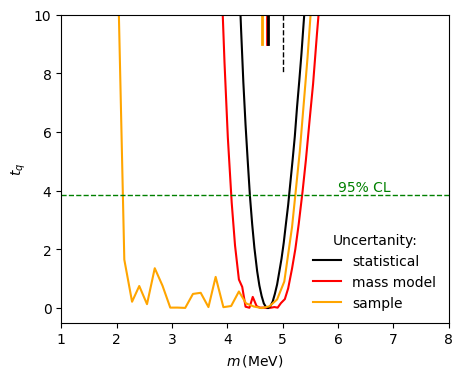

In [5]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(stat.Mdm, stat.Tq, label='statistical', c='k', zorder=2)
ax.plot(mm.Mdm, mm.Tq, label='mass model', c='r', zorder=1)
ax.plot(samp.Mdm, samp.Tq, label='sample', c='orange',lw=1.5)
ax.plot([stat.mdm_min]*2, [10, 9], c='k', lw=2, zorder=2)
ax.plot([mm.mdm_min]*2, [10, 9], c='r', lw=2, zorder=1)
ax.plot([samp.mdm_min]*2, [10, 9], c='orange', lw=2)
ax.plot([mdm0]*2, [10, 8], c='k', lw=1, ls='--')
ax.legend(frameon=False, loc='lower right', title='Uncertanity:')

ax.plot([1,8], [chi2.ppf(0.95, 1)]*2, c='green', ls='--', lw=1)
ax.set_ylim(-0.5, 10)
ax.set_xlim(1, 8)
ax.set_xlabel('$m\, \mathrm{(MeV)}$')
ax.set_ylabel('$t_q$')
ax.text(6, 4., '95% CL', color='green')
plt.savefig('../../Output/figures/mdm_tq.png', bbox_inches='tight', dpi=300)